### Simulate electron energy losses in matter considering both ionization and radiative losses

In [213]:
# First of all execute python script to load the defined functions 

%run functions.py 


In [216]:
import numpy as np  
from astropy import units as u
import matplotlib.pyplot as plt

# Define electron energy 

ek0 = 1000 * u.MeV
beta = _beta(ek0,me)
gamma = _gamma(ek0,me)

print('beta= ',beta)
print('gamma= ',gamma)


beta=  0.9999998695733578
gamma=  1957.9511834687132


In [217]:
# Look up material properties (water)
# https://pdg.lbl.gov/2024/AtomicNuclearProperties/HTML/water_liquid.html  

Z_A=0.55509 *u.mol / u.g #mol g^-1, atomic number Z over atomic mass mol g^-1 
rho=1 * u.g / u.cm**3 #g cm^-3, density of liquid water 
I=7.97e-5 * u.MeV #MeV, mean excitation energy

K=0.307075 * u.MeV * u.cm **2 / u.mol #MeV mol^−1 cm2
Ec = 78.60 * u.MeV
X0 = 36.08 * u.cm 

In [218]:
def de_dx_elec_ion(ek): 
    tmp_beta = _beta(ek,me)
    tmp_gamma = _gamma(ek,me)
    return 0.5*K*Z_A/tmp_beta**2 * ( np.log(me* tmp_beta**2 * tmp_gamma**2*(me*(tmp_gamma -1)/2.)/I**2) + 
                             (1 - tmp_beta**2) - (2*tmp_gamma-1)/tmp_gamma**2 *np.log(2) + 1/8. * ((tmp_gamma-1)/tmp_gamma)**2 )

def de_dx_elec_brem(ek): 
    return ek/X0 

In [220]:
de_dx_elec_ion(ek0) * rho

<Quantity 3.38361808 MeV / cm>

Text(0, 0.5, 'dE/dx X0 (MeV)')

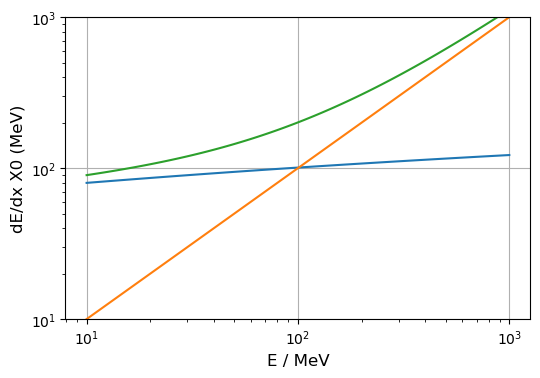

In [222]:
# Plot dE/dx XO for both energy loss functions in water as a function of the eletron energy. 
# Value for which they're equal should be the critican energy    

plt.figure(dpi=100)
e_points = np.logspace(1,3,100) * u.MeV

y_ion = de_dx_elec_ion(e_points) *rho * X0 
y_brem = de_dx_elec_brem(e_points) * X0

plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.ylim(10,1e3)
plt.plot(e_points, y_ion) 
plt.plot(e_points, y_brem) 
plt.plot(e_points, y_brem+y_ion) 

plt.xlabel('E / MeV', size=12)
plt.ylabel('dE/dx X0 (MeV)', size=12)

Text(0, 0.5, '$\\delta$')

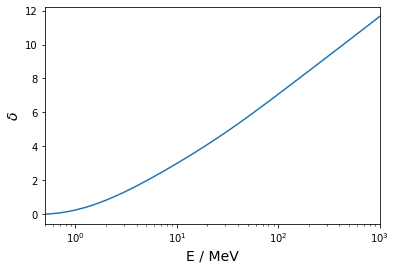

In [223]:
# To find exact Ec value, implement density correction to ionization energy loss 
# Load density effect from table (https://physics.nist.gov/PhysRefData/Star/Text/ESTAR.html)
e_delta , delta_factor = np.loadtxt('./delta_elec.txt', skiprows=8, usecols=(0,1), unpack=True) 
plt.xscale('log')
plt.xlim(5e-1,1e3)
plt.plot(e_delta,delta_factor)
plt.xlabel('E / MeV', size=14)
plt.ylabel('$\delta$', size=14)

In [224]:
# Define energy loss with additional density effect  

def de_dx_elec_ion_density(ek): 
    tmp_beta = _beta(ek,me)
    tmp_gamma = _gamma(ek,me)
    delta = np.interp(ek.value,e_delta,delta_factor) # Interplate table values 
    
    return 0.5*K*Z_A/tmp_beta**2 * ( np.log(me* tmp_beta**2 * tmp_gamma**2*(me*(tmp_gamma -1)/2.)/I**2) + 
                             (1 - tmp_beta**2) - (2*tmp_gamma-1)/tmp_gamma**2 *np.log(2) + 1/8. * ((tmp_gamma-1)/tmp_gamma)**2 - delta)


In [225]:
de_dx_elec_ion_density(10*u.MeV)

<Quantity 1.95765204 cm2 MeV / g>

Text(0, 0.5, 'dE/dx X0 / MeV')

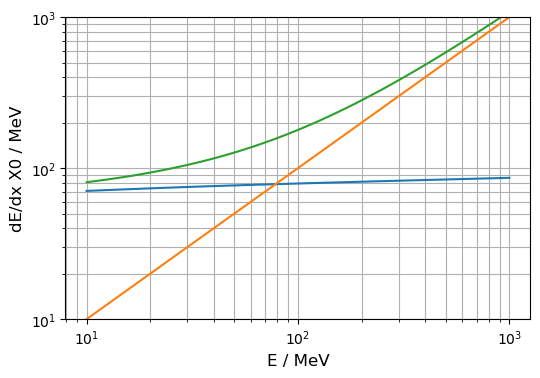

In [226]:
plt.figure(dpi=100)
e_points = np.logspace(1,3,100) * u.MeV

y_ion = de_dx_elec_ion_density(e_points) *rho * X0 
y_brem = de_dx_elec_brem(e_points) * X0

plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')

plt.ylim(10,1e3)
plt.plot(e_points, y_ion) 
plt.plot(e_points, y_brem) 
plt.plot(e_points, y_brem+y_ion) 

plt.xlabel('E / MeV', size=12)
plt.ylabel('dE/dx X0 / MeV', size=12)

### Function are implemented correctly, now compute energy loss
 
How much energy does an electron loose in 120 cm of water? \
How much due to radiative processes and how much due to ionization? 


In [228]:
h = 120 * u.cm  # Height of the tank 

deltaE_ion  = de_dx_elec_ion_density(ek0) * rho * h  
deltaE_brem  = de_dx_elec_brem(ek0) * h  

print(deltaE_ion)
print(deltaE_brem) # Too much, the electron is absorbed earlier! Must be done by steps, or just integrating the energy loss   

286.78433747405705 MeV
3325.9423503325943 MeV


In [229]:
dx = 1 * u.cm 
nsteps = int(h/dx)
d = 0.

ek0 = 1000 * u.MeV
ek = ek0
ek_array = []

etot_loss = 0. * u.MeV

tot_eloss_array = [] 
ion_eloss = []
brem_eloss = []
d_array = []

for i_step in range(nsteps): 
    
    d += dx 
    
    eloss_ion = de_dx_elec_ion_density(ek) * rho * dx 
    eloss_brem = de_dx_elec_brem(ek) * dx
    eloss = eloss_ion + eloss_brem
    
    ek = ek - eloss
    ion_eloss.append(eloss_ion.value)
    brem_eloss.append(eloss_brem.value)
    tot_eloss_array.append(eloss.value)
    ek_array.append(ek.value)
    d_array.append(d.value)
    
    etot_loss += eloss
    
    if(ek < 100 *u.keV): 
        print('Electron energy below 100 keV, terminate')
        break  
    
print('Total energy loss: ',etot_loss)

Electron energy below 100 keV, terminate
Total energy loss:  1000.3526722480514 MeV


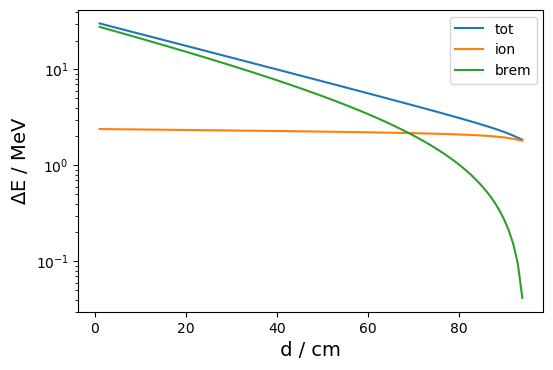

In [230]:
plt.figure(dpi=100)

plt.plot(d_array,tot_eloss_array, label = 'tot')
plt.plot(d_array,ion_eloss, label = 'ion')
plt.plot(d_array,brem_eloss, label='brem')

plt.xlabel(' d / cm ', size=14)
plt.ylabel(r'$\Delta$E / MeV',size=14)
plt.yscale('log')
plt.legend()



In [231]:
# Plot electron energy as a function of distance as well 
e_array = np.append(ek0.value, ek_array)
d_array = np.append(0, d_array)

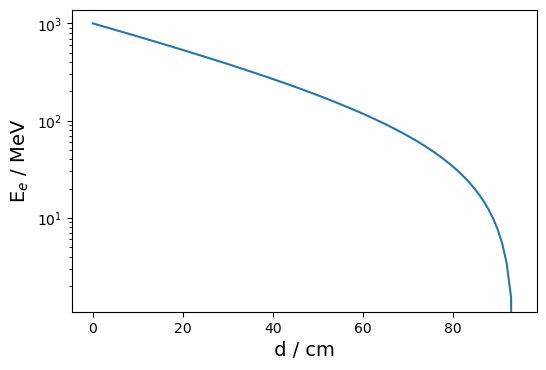

In [232]:
plt.figure(dpi=100)

plt.xlabel(' d / cm ', size=14)
plt.ylabel(r'E$_{e}$ / MeV',size=14)

plt.yscale('log')
plt.plot(d_array,e_array)
